# BERT

We shall implement BERT.  For this tutorial, you may want to first look at my Transformers tutorial to get a basic understanding of Transformers. 

For BERT, the main difference is on how we process the datasets, i.e., masking.   Aside from that, the backbone model is still the Transformers.

In [47]:
import math
import re
from   random import *
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from datasets import load_dataset
import spacy
import pickle
import time

# Set device as GPU if available, else set to CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'
print(device)

#make our work comparable if restarted the kernel
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

cuda


## 1. Data

For simplicity, we shall use very simple data like this.

### Loading dataset

In [48]:
# Load a portion of the WikiAnswers dataset
dataset = load_dataset("embedding-data/QQP_triplets")

### Put 'query', 'pos' and 'neg' from each sample into a list

In [49]:
text = []
for i in range(len(dataset['train'])):
    all_sents = [dataset['train'][i]['set']['query']] + dataset['train'][i]['set']['pos'] + dataset['train'][i]['set']['neg']
    text.extend(all_sents)

In [50]:
len(text) #number of sentences

2995804

In [51]:
text = [x.lower() for x in text] #lower case
text = [re.sub("[.,!?\\-]", '', x) for x in text] #clean all symbols

In [52]:
for sentence in text:
    print(sentence, "_____")
    words = sentence.split()
    print(words)
    break

why in india do we not have one on one political debate as in usa _____
['why', 'in', 'india', 'do', 'we', 'not', 'have', 'one', 'on', 'one', 'political', 'debate', 'as', 'in', 'usa']


In [53]:
### limit datasize
text_lim = text[0:10000]

In [54]:
text_lim[1]

'why cant we have a public debate between politicians in india like the one in us'

### Making vocabs

Before making the vocabs, let's remove all question marks and perios, etc, then turn everything to lowercase, and then simply split the text. 

In [55]:
data = {} # to save parameters

In [56]:
# combine everything into one to make vocabs
word_list = list(set(" ".join(text_lim).split()))
word2id = {'[PAD]': 0, '[CLS]': 1, '[SEP]': 2, '[MASK]': 3, '[UNK]': 4}  #special tokens.

#create the word2id
for i, w in enumerate(word_list):
    word2id[w] = i + 5  #because 0-3 are already occupied
    id2word = {i: w for i, w in enumerate(word2id)}
    vocab_size = len(word2id)

#list of all tokens for whole text_lim
token_list = list()
for sentence in text_lim:
    arr = [word2id[word] for word in sentence.split()]
    token_list.append(arr)

In [57]:
data['vocab_size'] = vocab_size
data['word2id'] = word2id

## 2. Data loader

We gonna make dataloader.  Inside here, we need to make two types of embeddings: **token embedding** and **segment embedding**

1. **Token embedding** - Given “The cat is walking. The dog is barking”, we add [CLS] and [SEP] >> “[CLS] the cat is walking [SEP] the dog is barking”. 

2. **Segment embedding**
A segment embedding separates two sentences, i.e., [0 0 0 0 1 1 1 1 ]

3. **Masking**
As mentioned in the original paper, BERT randomly assigns masks to 15% of the sequence. In this 15%, 80% is replaced with masks, while 10% is replaced with random tokens, and the rest 10% is left as is.  Here we specified `max_pred` 

4. **Padding**
Once we mask, we will add padding. For simplicity, here we padded until some specified `max_len`. 

Note:  `positive` and `negative` are just simply counts to keep track of the batch size.  `positive` refers to two sentences that are really next to one another.

In [58]:
batch_size = 6
max_mask   = 5  # max masked tokens when 15% exceed, it will only be max_pred
max_len    = 1000 # maximum of length to be padded; 

In [59]:
data['batch_size'] = batch_size
data['max_mask'] = max_mask
data['max_len'] = max_len

In [60]:
def make_batch():
    batch = []
    positive = negative = 0  #count of batch size;  we want to have half batch that are positive pairs (i.e., next sentence pairs)
    while positive != batch_size/2 or negative != batch_size/2:
        
        #randomly choose two sentence so we can put [SEP]
        tokens_a_index, tokens_b_index= randrange(len(text_lim)), randrange(len(text_lim))
        #retrieve the two sentences
        tokens_a, tokens_b= token_list[tokens_a_index], token_list[tokens_b_index]

        #1. token embedding - append CLS and SEP
        input_ids = [word2id['[CLS]']] + tokens_a + [word2id['[SEP]']] + tokens_b + [word2id['[SEP]']]

        #2. segment embedding - [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]
        segment_ids = [0] * (1 + len(tokens_a) + 1) + [1] * (len(tokens_b) + 1)

        #3. mask language modeling
        #masked 15%, but should be at least 1 but does not exceed max_mask
        n_pred =  min(max_mask, max(1, int(round(len(input_ids) * 0.15))))
        #get the pos that excludes CLS and SEP and shuffle them
        cand_maked_pos = [i for i, token in enumerate(input_ids) if token != word2id['[CLS]'] and token != word2id['[SEP]']]
        shuffle(cand_maked_pos)
        masked_tokens, masked_pos = [], []
        #simply loop and change the input_ids to [MASK]
        for pos in cand_maked_pos[:n_pred]:
            masked_pos.append(pos)  #remember the position
            masked_tokens.append(input_ids[pos]) #remember the tokens
            #80% replace with a [MASK], but 10% will replace with a random token
            if random() < 0.1:  # 10%
                index = randint(0, vocab_size - 1) # random index in vocabulary
                input_ids[pos] = word2id[id2word[index]] # replace
            elif random() < 0.9:  # 80%
                input_ids[pos] = word2id['[MASK]'] # make mask
            else:  #10% do nothing
                pass

        # pad the input_ids and segment ids until the max len
        n_pad = max_len - len(input_ids)
        input_ids.extend([0] * n_pad)
        segment_ids.extend([0] * n_pad)

        # pad the masked_tokens and masked_pos to make sure the lenth is max_mask
        if max_mask > n_pred:
            n_pad = max_mask - n_pred
            masked_tokens.extend([0] * n_pad)
            masked_pos.extend([0] * n_pad)

        #check if first sentence is really comes before the second sentence
        #also make sure positive is exactly half the batch size
        if tokens_a_index + 1 == tokens_b_index and positive < batch_size / 2:
            batch.append([input_ids, segment_ids, masked_tokens, masked_pos, True]) # IsNext
            positive += 1
        elif tokens_a_index + 1 != tokens_b_index and negative < batch_size/2:
            batch.append([input_ids, segment_ids, masked_tokens, masked_pos, False]) # NotNext
            negative += 1
            
    return batch

In [61]:
batch = make_batch()

In [62]:
#len of batch
len(batch)

6

In [63]:
#we can deconstruct using map and zip
input_ids, segment_ids, masked_tokens, masked_pos, isNext = map(torch.LongTensor, zip(*batch))
input_ids.shape, segment_ids.shape, masked_tokens.shape, masked_pos.shape, isNext.shape

(torch.Size([6, 1000]),
 torch.Size([6, 1000]),
 torch.Size([6, 5]),
 torch.Size([6, 5]),
 torch.Size([6]))

## 3. Model

Recall that BERT only uses the encoder.

BERT has the following components:

- Embedding layers
- Attention Mask
- Encoder layer
- Multi-head attention
- Scaled dot product attention
- Position-wise feed-forward network
- BERT (assembling all the components)

## 3.1 Embedding

Here we simply generate the positional embedding, and sum the token embedding, positional embedding, and segment embedding together.

<img src = "figures/BERT_embed.png" width=500>

In [64]:
class Embedding(nn.Module):
    def __init__(self):
        super(Embedding, self).__init__()
        self.tok_embed = nn.Embedding(vocab_size, d_model)  # token embedding
        self.pos_embed = nn.Embedding(max_len, d_model)      # position embedding
        self.seg_embed = nn.Embedding(n_segments, d_model)  # segment(token type) embedding
        self.norm = nn.LayerNorm(d_model)
        self.device = device

    def forward(self, x, seg):
        # x, seg: (bs, len)
        seq_len = x.size(1)
        pos = torch.arange(seq_len, dtype=torch.long, device=self.device)
        pos = pos.unsqueeze(0).expand_as(x)  # (len,) -> (bs, len)
        embedding = self.tok_embed(x) + self.pos_embed(pos) + self.seg_embed(seg)
        return self.norm(embedding)

## 3.2 Attention mask

In [65]:
def get_attn_pad_mask(seq_q, seq_k):
    batch_size, len_q = seq_q.size()
    batch_size, len_k = seq_k.size()
    # eq(zero) is PAD token
    pad_attn_mask = seq_k.data.eq(0).unsqueeze(1)  # batch_size x 1 x len_k(=len_q), one is masking
    return pad_attn_mask.expand(batch_size, len_q, len_k)  # batch_size x len_q x len_k

### Testing the attention mask

In [66]:
print(get_attn_pad_mask(input_ids, input_ids).shape)

torch.Size([6, 1000, 1000])


## 3.3 Encoder

The encoder has two main components: 

- Multi-head Attention
- Position-wise feed-forward network

First let's make the wrapper called `EncoderLayer`

In [67]:
class EncoderLayer(nn.Module):
    def __init__(self):
        super(EncoderLayer, self).__init__()
        self.enc_self_attn = MultiHeadAttention()
        self.pos_ffn       = PoswiseFeedForwardNet()

    def forward(self, enc_inputs, enc_self_attn_mask):
        enc_outputs, attn = self.enc_self_attn(enc_inputs, enc_inputs, enc_inputs, enc_self_attn_mask) # enc_inputs to same Q,K,V
        enc_outputs = self.pos_ffn(enc_outputs) # enc_outputs: [batch_size x len_q x d_model]
        return enc_outputs, attn

Let's define the scaled dot attention, to be used inside the multihead attention

In [68]:
class ScaledDotProductAttention(nn.Module):
    def __init__(self):
        super(ScaledDotProductAttention, self).__init__()

    def forward(self, Q, K, V, attn_mask):
        scores = torch.matmul(Q, K.transpose(-1, -2)) / np.sqrt(d_k) # scores : [batch_size x n_heads x len_q(=len_k) x len_k(=len_q)]
        scores.masked_fill_(attn_mask, -1e9) # Fills elements of self tensor with value where mask is one.
        attn = nn.Softmax(dim=-1)(scores)
        context = torch.matmul(attn, V)
        return context, attn 

Let's define the parameters first

In [69]:
n_layers = 6    # number of Encoder of Encoder Layer
n_heads  = 8    # number of heads in Multi-Head Attention
d_model  = 768  # Embedding Size
d_ff = 768 * 4  # 4*d_model, FeedForward dimension
d_k = d_v = 64  # dimension of K(=Q), V
n_segments = 2

In [70]:
data['n_layers'] = n_layers
data['n_heads'] = n_heads
data['d_model'] = d_model
data['d_ff'] = d_ff
data['d_k'] = d_k
data['d_v'] = d_v
data['n_segments'] = n_segments

Here is the Multiheadattention.

In [71]:
class MultiHeadAttention(nn.Module):
    def __init__(self):
        super(MultiHeadAttention, self).__init__()
        self.W_Q = nn.Linear(d_model, d_k * n_heads).to(device)
        self.W_K = nn.Linear(d_model, d_k * n_heads).to(device)
        self.W_V = nn.Linear(d_model, d_v * n_heads).to(device)

    def forward(self, Q, K, V, attn_mask):
        # q: [batch_size x len_q x d_model], k: [batch_size x len_k x d_model], v: [batch_size x len_k x d_model]
        residual, batch_size = Q, Q.size(0)
        # (B, S, D) -proj-> (B, S, D) -split-> (B, S, H, W) -trans-> (B, H, S, W)
        q_s = self.W_Q(Q).view(batch_size, -1, n_heads, d_k).transpose(1, 2)  # q_s: [batch_size x n_heads x len_q x d_k]
        k_s = self.W_K(K).view(batch_size, -1, n_heads, d_k).transpose(1, 2)  # k_s: [batch_size x n_heads x len_k x d_k]
        v_s = self.W_V(V).view(batch_size, -1, n_heads, d_v).transpose(1, 2)  # v_s: [batch_size x n_heads x len_k x d_v]

        attn_mask = attn_mask.unsqueeze(1).repeat(1, n_heads, 1, 1).to(device)  # attn_mask : [batch_size x n_heads x len_q x len_k]

        # context: [batch_size x n_heads x len_q x d_v], attn: [batch_size x n_heads x len_q(=len_k) x len_k(=len_q)]
        context, attn = ScaledDotProductAttention()(q_s, k_s, v_s, attn_mask)
        context = context.transpose(1, 2).contiguous().view(batch_size, -1, n_heads * d_v)
        output = nn.Linear(n_heads * d_v, d_model).to(device)(context)
        return nn.LayerNorm(d_model).to(device)(output + residual), attn  # output: [batch_size x len_q x d_model]


Here is the PoswiseFeedForwardNet.

In [72]:
class PoswiseFeedForwardNet(nn.Module):
    def __init__(self):
        super(PoswiseFeedForwardNet, self).__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)

    def forward(self, x):
        # (batch_size, len_seq, d_model) -> (batch_size, len_seq, d_ff) -> (batch_size, len_seq, d_model)
        return self.fc2(F.gelu(self.fc1(x)))


## 3.4 Putting them together

In [73]:
class BERT(nn.Module):
    def __init__(self):
        super(BERT, self).__init__()
        self.embedding = Embedding().to(device)
        self.layers = nn.ModuleList([EncoderLayer() for _ in range(n_layers)])
        self.fc = nn.Linear(d_model, d_model).to(device)
        self.activ = nn.Tanh()
        self.linear = nn.Linear(d_model, d_model).to(device)
        self.norm = nn.LayerNorm(d_model).to(device)
        self.classifier = nn.Linear(d_model, 2).to(device)
        # decoder is shared with embedding layer
        embed_weight = self.embedding.tok_embed.weight
        n_vocab, n_dim = embed_weight.size()
        self.decoder = nn.Linear(n_dim, n_vocab, bias=False).to(device)
        self.decoder.weight = embed_weight
        self.decoder_bias = nn.Parameter(torch.zeros(n_vocab)).to(device)

    def forward(self, input_ids, segment_ids, masked_pos):
        input_ids = input_ids.to(self.embedding.tok_embed.weight.device)
        segment_ids = segment_ids.to(self.embedding.tok_embed.weight.device)
        masked_pos = masked_pos.to(self.embedding.tok_embed.weight.device)

        output = self.embedding(input_ids, segment_ids)
        enc_self_attn_mask = get_attn_pad_mask(input_ids, input_ids)
        for layer in self.layers:
            output, enc_self_attn = layer(output, enc_self_attn_mask)
        # output : [batch_size, len, d_model], attn : [batch_size, n_heads, d_mode, d_model]
        
        # 1. predict next sentence
        # it will be decided by first token(CLS)
        h_pooled   = self.activ(self.fc(output[:, 0])) # [batch_size, d_model]
        logits_nsp = self.classifier(h_pooled) # [batch_size, 2]

        # 2. predict the masked token
        masked_pos = masked_pos[:, :, None].expand(-1, -1, output.size(-1)) # [batch_size, max_pred, d_model]
        h_masked = torch.gather(output, 1, masked_pos) # masking position [batch_size, max_pred, d_model]
        h_masked  = self.norm(F.gelu(self.linear(h_masked)))
        logits_lm = self.decoder(h_masked) + self.decoder_bias # [batch_size, max_pred, n_vocab]

        return output, logits_lm, logits_nsp

## 4. Training

In [74]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [75]:
num_epoch = 100
model = BERT()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


model = model.to(device)

total_start = time.time()
train_losses = []
for epoch in range(num_epoch):
    if (epoch - 1) % 10 == 0:
        start_time = time.time()
    optimizer.zero_grad()

    batch = make_batch()
    # batch = batch.to(device)
    input_ids, segment_ids, masked_tokens, masked_pos, isNext = map(torch.LongTensor, zip(*batch))
    input_ids = input_ids.to(device)
    segment_ids = segment_ids.to(device)
    masked_tokens = masked_tokens.to(device)
    masked_pos = masked_pos.to(device)
    isNext = isNext.to(device)
    
    _, logits_lm, logits_nsp = model(input_ids, segment_ids, masked_pos)    
    #logits_lm: (bs, max_mask, vocab_size) ==> (6, 5, 34)
    #logits_nsp: (bs, yes/no) ==> (6, 2)

    #1. mlm loss
    #logits_lm.transpose: (bs, vocab_size, max_mask) vs. masked_tokens: (bs, max_mask)
    loss_lm = criterion(logits_lm.transpose(1, 2), masked_tokens) # for masked LM
    loss_lm = (loss_lm.float()).mean()
    #2. nsp loss
    #logits_nsp: (bs, 2) vs. isNext: (bs, )
    loss_nsp = criterion(logits_nsp, isNext) # for sentence classification
    
    #3. combine loss
    loss = loss_lm + loss_nsp
    train_losses.append(loss)
    if epoch % 10 == 0:
        end_time = time.time()
        
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        print('Epoch:', '%02d' % (epoch), 'loss =', '{:.6f}'.format(loss))
        print(f'Time: {epoch_mins}m {epoch_secs}s')
    loss.backward()
    optimizer.step()

total_end = time.time()
total_min, total_sec = epoch_time(total_start, total_end)
print(f'Training Time: {total_min}m {total_sec}s')

Epoch: 00 loss = 107.460434
Time: 53m 22s
Epoch: 10 loss = 67.292274
Time: 0m 30s
Epoch: 20 loss = 55.878735
Time: 0m 33s
Epoch: 30 loss = 36.697475
Time: 0m 35s
Epoch: 40 loss = 37.386932
Time: 0m 44s
Epoch: 50 loss = 27.557808
Time: 0m 45s
Epoch: 60 loss = 26.519478
Time: 0m 40s
Epoch: 70 loss = 27.267021
Time: 0m 38s
Epoch: 80 loss = 22.632566
Time: 0m 28s
Epoch: 90 loss = 25.216793
Time: 0m 26s
Training Time: 6m 5s


In [76]:
import matplotlib.pyplot as plt

def plot_losses(losses):
    # Transfer tensor data from GPU to CPU
    losses = [loss.item() for loss in losses]

    plt.plot(losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Epochs')
    plt.legend()
    plt.show()

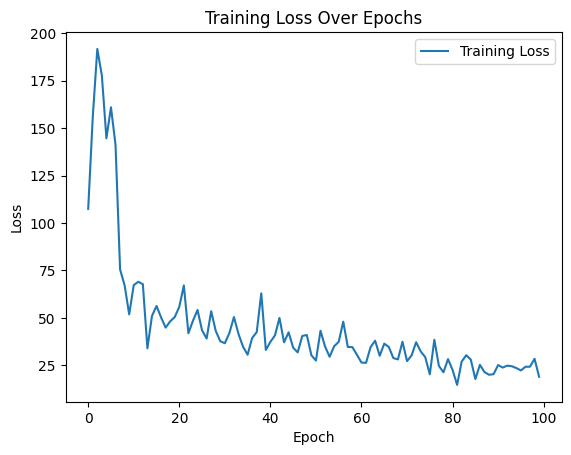

In [77]:
plot_losses(train_losses)

## 5. Inference

Since our dataset is very small, it won't work very well, but just for the sake of demonstration.

In [78]:
# Predict mask tokens ans isNext
input_ids, segment_ids, masked_tokens, masked_pos, isNext = map(torch.LongTensor, zip(batch[2]))
print([id2word[w.item()] for w in input_ids[0] if id2word[w.item()] != '[PAD]'])

_, logits_lm, logits_nsp = model(input_ids, segment_ids, masked_pos)
#logits_lm:  (1, max_mask, vocab_size) ==> (1, 5, 34)
#logits_nsp: (1, yes/no) ==> (1, 2)
logits_lm = logits_lm.cpu()
logits_nsp = logits_nsp.cpu()

#predict masked tokens
#max the probability along the vocab dim (2), [1] is the indices of the max, and [0] is the first value
logits_lm = logits_lm.data.max(2)[1][0].data.numpy() 
#note that zero is padding we add to the masked_tokens
print('masked tokens (words) : ',[id2word[pos.item()] for pos in masked_tokens[0]])
print('masked tokens list : ',[pos.item() for pos in masked_tokens[0]])
print('masked tokens (words) : ',[id2word[pos.item()] for pos in logits_lm])
print('predict masked tokens list : ', [pos for pos in logits_lm])

#predict nsp
logits_nsp = logits_nsp.data.max(1)[1][0].data.numpy()
print(logits_nsp)
print('isNext : ', True if isNext else False)
print('predict isNext : ',True if logits_nsp else False)

['[CLS]', '[MASK]', 'is', '[MASK]', 'best', 'mba', 'college', 'in', 'banglore', 'for', 'hr', '[SEP]', 'why', 'are', 'you', 'not', '[MASK]', 'in', 'democracy', 'of', 'india', '[SEP]']
masked tokens (words) :  ['the', 'which', 'believing', '[PAD]', '[PAD]']
masked tokens list :  [2626, 288, 7918, 0, 0]
masked tokens (words) :  ['[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']
predict masked tokens list :  [0, 0, 0, 0, 0]
0
isNext :  False
predict isNext :  False


Trying a bigger dataset should be able to see the difference.

In [79]:
save_path = f'./app/models/model.pt'
torch.save(model.state_dict(), save_path)

In [80]:
pickle.dump(data, open('./app/models/data.pkl', 'wb'))